In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.special import legendre, spherical_jn

from classy import Class
from fftlog import FFTLog, MPC

In [2]:
font = {'size': 14}
axislabelfontsize='large'
matplotlib.rc('font', **font)

redshift bin, skycut, and wide-angle expansion order: 

In [3]:
red, sky, nwide = "cmass", "ngc", 0

Computes the sky-mask convolution matrix $W_{l,l'}(k, p)$ from the window functions $Q_{L}(s)$ : 

\begin{equation}
    W_{\ell, \ell'}(k, p) = \frac{2}{\pi} (2\ell+1) (-i)^\ell i^{\ell'} \int ds \ s^2 j_\ell(ks) j_{\ell'}(p s) \sum_L \left(\begin{matrix}
\ell & L & \ell'\\
0 & 0 & 0
\end{matrix}\right)^2 Q_L(s) \ 
\end{equation}

such that 
\begin{equation}
P_l(k) = \int dp \ p^2 \sum_{l'} W_{l,l'}(k,p) P_{l'}(p) \ .
\end{equation}

Refer to App. A of 2208.05930 for derivations of these equations.

Configure $k$ and $p$

In [4]:
# this array should corresponds to the k-bins of the power spectrum data
# k_data = np.arange(0.005, 0.40, 0.01)

Lbox, n0, dn = 3500., 3, 6
kf = 2 * np.pi / Lbox
nmax = dn * (np.floor(0.40/kf) // dn) - dn
k_data = np.arange(n0,nmax+dn,dn) * kf
with np.printoptions(precision=4): print(k_data)

[0.0054 0.0162 0.0269 0.0377 0.0485 0.0592 0.07   0.0808 0.0916 0.1023
 0.1131 0.1239 0.1346 0.1454 0.1562 0.167  0.1777 0.1885 0.1993 0.21
 0.2208 0.2316 0.2424 0.2531 0.2639 0.2747 0.2854 0.2962 0.307  0.3177
 0.3285 0.3393 0.3501 0.3608 0.3716 0.3824 0.3931]


In [5]:
# thin k and p on which we compute W_{l,l'}(k, p).
k_arr = np.concatenate([[1e-4, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175], np.arange(0.02, 0.41, 5e-3) ])
# k_arr = np.array([0.1, 0.2, 0.3])
p_arr = np.concatenate([ np.geomspace(1e-4, 0.003, 20, endpoint=False) , np.arange(0.003, 0.7, 5e-4) ])
deltap = p_arr[1:] - p_arr[:-1]
deltap = np.concatenate([[0], deltap])
print (k_data.shape, k_arr.shape, p_arr.shape)


(37,) (89,) (1414,)


Loading $Q_{l}(s)$

In [6]:
ss, Q0, Q1, Q2, Q3, Q4 = np.loadtxt(os.path.join("Qs", "Qs_n%s_boss_%s_%s.dat") % (nwide, red, sky), unpack=True)
Qs = np.array([Q0, Q1, Q2, Q3, Q4])

Coefficients $(2\ell+1) \left(\begin{matrix}
\ell & L & \ell'\\
0 & 0 & 0
\end{matrix}\right)^2 $

In [7]:
from sympy.physics.wigner import wigner_3j
ClLm = np.array([[[
    (2*l+1)*float(wigner_3j(l, L, p, 0, 0, 0)**2) for p in range(5)] for L in range(5)] for l in range(5)])
# print (ClLm)

$W_{l,l'}(k,p)$ from $Q_{L}(s)$ by FFTLog on $j_{\ell'}(p s)$

In [8]:
def getW(s, QLs, k_array, p_array, Nl=5):
    Qlm = np.einsum('lLm,Ls->lms', ClLm[:Nl,:Nl,:Nl], QLs[:Nl])
    fftsettings = dict(Nmax=2048, xmin=1.e-2, xmax=1.e6, bias=-1.6)     
    fft = FFTLog(**fftsettings)
    pPow = np.exp(np.einsum('n,s->ns', -fft.Pow-3., np.log(p_array)))
    M = np.empty(shape=(Nl, fft.Pow.shape[0]), dtype='complex')
    for l in range(Nl): M[l] = 4 * np.pi * MPC(l, -0.5*fft.Pow) # the factors of pi are correct
    Coef = np.empty(shape=(Nl, Nl, len(k_array), fft.Pow.shape[0]), dtype='complex')
    for l in range(Nl):
        for m in range(Nl):
            for i, k in enumerate(k_array):
                Coef[l,m,i] = (-1j)**l * 1j**m * fft.Coef(s, Qlm[l,m]*spherical_jn(l, k*s), extrap = 'padding')
    Wlm = np.einsum('lmkn,np,mn->lmkp', Coef, pPow, M) 
    return Wlm

In [9]:
Wlm_c = getW(ss, Qs, k_arr, p_arr) # this may take a few minutes

Check integral over p is equal to the window normalization in the limit of $k\rightarrow \infty$:  $\int dp \ p^2 W_{0,0}(k, p) = Q_0(s\rightarrow 0)$.

In [10]:
for i, k in enumerate(k_arr):
    norm = np.sum(np.real(Wlm_c[0, 0]) * p_arr**2 * deltap, axis=-1)[i] / Qs[0,0]
    print ('%.3f:%.2f' % (k, norm), end = ' | ')

0.000:0.97 | 0.001:0.97 | 0.001:0.97 | 0.002:0.97 | 0.003:0.98 | 0.005:0.99 | 0.007:1.00 | 0.010:1.00 | 0.013:1.00 | 0.015:1.00 | 0.018:1.00 | 0.020:1.00 | 0.025:1.00 | 0.030:1.00 | 0.035:1.00 | 0.040:1.00 | 0.045:1.00 | 0.050:1.00 | 0.055:1.00 | 0.060:1.00 | 0.065:1.00 | 0.070:1.00 | 0.075:1.00 | 0.080:1.00 | 0.085:1.00 | 0.090:1.00 | 0.095:1.00 | 0.100:1.00 | 0.105:1.00 | 0.110:1.00 | 0.115:1.00 | 0.120:1.00 | 0.125:1.00 | 0.130:1.00 | 0.135:1.00 | 0.140:1.00 | 0.145:1.00 | 0.150:1.00 | 0.155:1.00 | 0.160:1.00 | 0.165:1.00 | 0.170:1.00 | 0.175:1.00 | 0.180:1.00 | 0.185:1.00 | 0.190:1.00 | 0.195:1.00 | 0.200:1.00 | 0.205:1.00 | 0.210:1.00 | 0.215:1.00 | 0.220:1.00 | 0.225:1.00 | 0.230:1.00 | 0.235:1.00 | 0.240:1.00 | 0.245:1.00 | 0.250:1.00 | 0.255:1.00 | 0.260:1.00 | 0.265:1.00 | 0.270:1.00 | 0.275:1.00 | 0.280:1.00 | 0.285:1.00 | 0.290:1.00 | 0.295:1.00 | 0.300:1.00 | 0.305:1.00 | 0.310:1.00 | 0.315:1.00 | 0.320:1.00 | 0.325:1.00 | 0.330:1.00 | 0.335:1.00 | 0.340:1.00 | 0.345:1.00 |

Adding the integral constraint (see e.g. 1904.08851 or eqs. (2.1), (2.7) of 2106.06324):

\begin{equation}
W_{l,l'}(k,p) \rightarrow W_{l,l'}(k,p) - \frac{\tilde Q_l(k)}{\tilde Q_0(0)} W_{0,l'}(0,p)
\end{equation}

Loading $\tilde Q_{\ell'}(k)$

In [11]:
kk, Q0, Q1, Q2, Q3, Q4 = np.loadtxt(os.path.join("Qk", "Qk_n0_boss_%s_%s.dat") % ( red, sky), unpack=True)
Qk = np.array([Q0, 1j*Q1, Q2, 1j*Q3, Q4]) / Q0[0]
Qk = interp1d(kk, Qk, axis=-1, bounds_error=False, fill_value=0)(k_arr)

In [12]:
### In principle, this is the right formula:
# Wlm_cic = Wlm - np.einsum('lk,mp->lmkp', Qk, Wlm[0,:,0,:])

### However, since the IC is a totally negligible effect for ell=2,4, 
### and since the Q_\ell(k) are somewhat noisy for ell=2,4 when k --> 0, I simply put it for ell=0
Wlm_cic = 1. * Wlm_c 
Wlm_cic[0] -= np.einsum('lk,mp->lmkp', Qk, Wlm_c[0,:,0,:])[0]

Check integral over p is equal to the window normalization in the limit of $k\rightarrow \infty$:  $\int dp \ p^2 W_{0,0}(k, p) = Q_0(s\rightarrow 0)$, and $=0$ in the limit $k\rightarrow 0$: 

In [13]:
for i, k in enumerate(k_arr):
    norm = np.sum(np.real(Wlm_cic[0, 0]) * p_arr**2 * deltap, axis=-1)[i] / Qs[0,0]
    print ('%.3f:%.2f' % (k, norm), end = ' | ')

0.000:0.00 | 0.001:0.06 | 0.001:0.23 | 0.002:0.63 | 0.003:0.86 | 0.005:0.97 | 0.007:0.99 | 0.010:1.00 | 0.013:1.00 | 0.015:1.00 | 0.018:1.00 | 0.020:1.00 | 0.025:1.00 | 0.030:1.00 | 0.035:1.00 | 0.040:1.00 | 0.045:1.00 | 0.050:1.00 | 0.055:1.00 | 0.060:1.00 | 0.065:1.00 | 0.070:1.00 | 0.075:1.00 | 0.080:1.00 | 0.085:1.00 | 0.090:1.00 | 0.095:1.00 | 0.100:1.00 | 0.105:1.00 | 0.110:1.00 | 0.115:1.00 | 0.120:1.00 | 0.125:1.00 | 0.130:1.00 | 0.135:1.00 | 0.140:1.00 | 0.145:1.00 | 0.150:1.00 | 0.155:1.00 | 0.160:1.00 | 0.165:1.00 | 0.170:1.00 | 0.175:1.00 | 0.180:1.00 | 0.185:1.00 | 0.190:1.00 | 0.195:1.00 | 0.200:1.00 | 0.205:1.00 | 0.210:1.00 | 0.215:1.00 | 0.220:1.00 | 0.225:1.00 | 0.230:1.00 | 0.235:1.00 | 0.240:1.00 | 0.245:1.00 | 0.250:1.00 | 0.255:1.00 | 0.260:1.00 | 0.265:1.00 | 0.270:1.00 | 0.275:1.00 | 0.280:1.00 | 0.285:1.00 | 0.290:1.00 | 0.295:1.00 | 0.300:1.00 | 0.305:1.00 | 0.310:1.00 | 0.315:1.00 | 0.320:1.00 | 0.325:1.00 | 0.330:1.00 | 0.335:1.00 | 0.340:1.00 | 0.345:1.00 |

Plot $W_{l,l'}(k,p)$ for some $k$'s

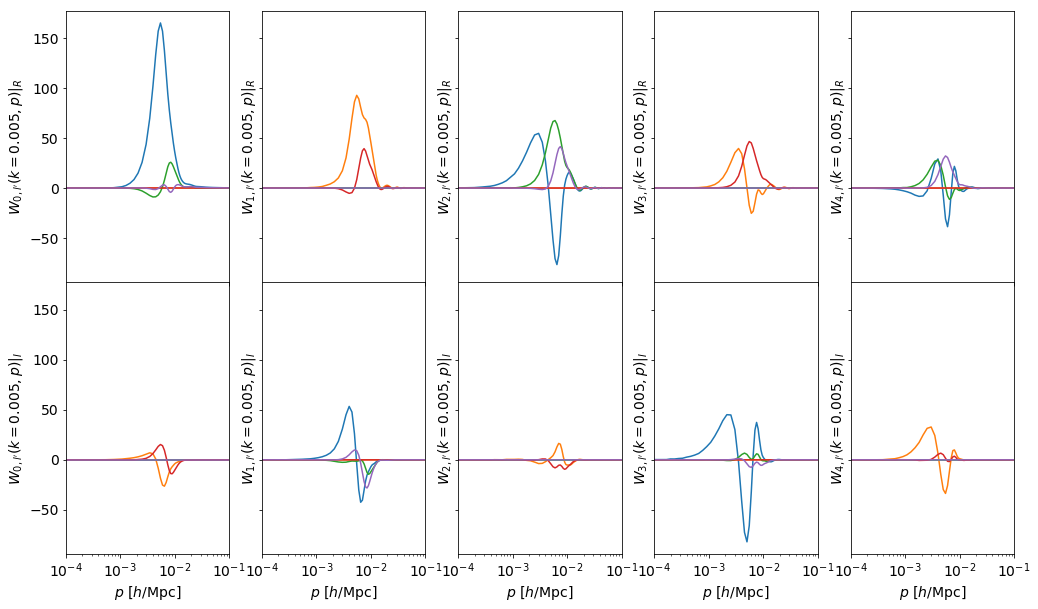

In [14]:
fig, ax = plt.subplots(2,5, figsize=(17, 10), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.2, hspace=0.)

idk = 5
for l in range(5):
    for m in range(5):
        ax[0,l].plot(p_arr, np.real(Wlm_cic[l,m,idk]) * p_arr**2)
        ax[1,l].plot(p_arr, np.imag(Wlm_cic[l,m,idk]) * p_arr**2)
    for i in range(2):
        ax[i,l].set_xlim(1e-4, 1e-1)
        ax[i,l].set_xscale('log')
    ax[0,l].set_ylabel(r"$W_{%s,l^\prime}(k=%.3f,p)|_R$" % (l,k_arr[idk]))
    ax[1,l].set_ylabel(r"$W_{%s,l^\prime}(k=%.3f,p)|_I$" % (l,k_arr[idk]))
    ax[1,l].set_xlabel(r'$p \ [h/{\rm Mpc}]$')
    
plt.show()

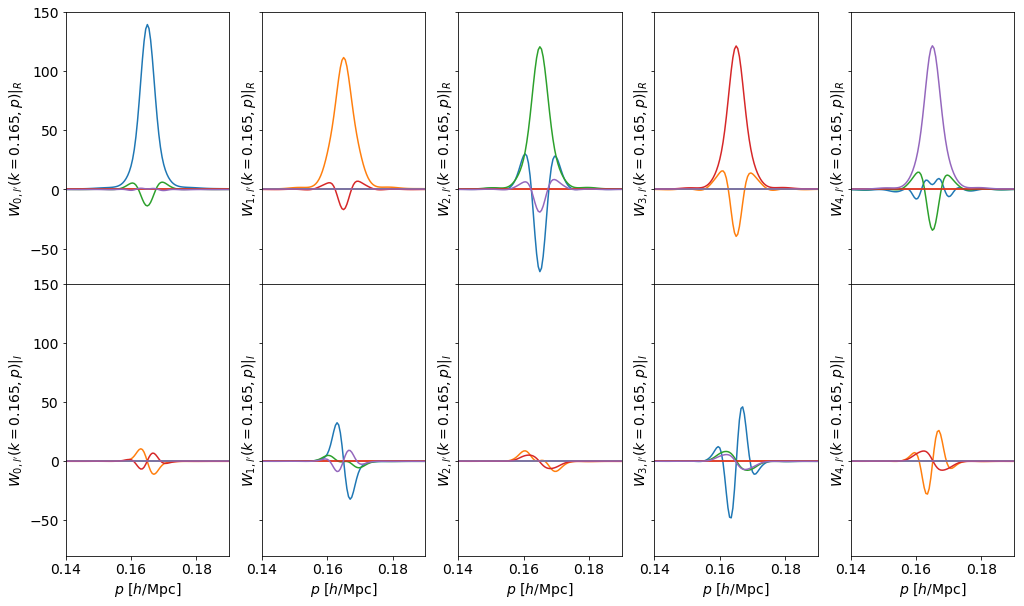

In [15]:
fig, ax = plt.subplots(2,5, figsize=(17, 10), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.2, hspace=0.)

idk = 40
for l in range(5):
    for m in range(5):
        ax[0,l].plot(p_arr, np.real(Wlm_cic[l,m,idk]) * p_arr**2)
        ax[1,l].plot(p_arr, np.imag(Wlm_cic[l,m,idk]) * p_arr**2)
    for i in range(2):
        ax[i,l].set_xlim(k_arr[idk]-0.025, k_arr[idk]+0.025)
    ax[0,l].set_ylabel(r"$W_{%s,l^\prime}(k=%.3f,p)|_R$" % (l,k_arr[idk]))
    ax[1,l].set_ylabel(r"$W_{%s,l^\prime}(k=%.3f,p)|_I$" % (l,k_arr[idk]))
    ax[1,l].set_xlabel(r'$p \ [h/{\rm Mpc}]$')

plt.show()

We bin on the left (k-bins). 

For the deconvolution, one would integrate on the right (over p). However, in order to get a square matrix so that it can be inverted, one needs to approximate the integral that runs over p from 0 to infinity by a discrete sum on $N$ points, where $N$ is the number of data points. For BOSS, we find that this approximation is good enough. However, in general, we prefer to do the convolution on the theory model. 

We therefore provide the k-binned $\Delta p \ p^2  W_{l,l'}(k,p)$ to be convolved with the theory model (with a simple matrix multiplication over the thin array of p's): 

\begin{equation}
P_l(k) = \sum_{l'}  \int dp \ p^2 W_{l,l'}(k,p) P_{l'}(p) \simeq \sum_{l'} \sum_p \Delta p \ p^2 W_{l,l'}(k,p) P_{l'}(p)
\end{equation}

In [16]:
def intright(setxout, setxin, Wal):
    """Integrate over the p to get to k_data (approximately)"""
    delta_k = setxout[-1] - setxout[-2]
    kcentral = setxout #(setxout[-1] - delta_k * np.arange(len(setxout)))[::-1]
    binmin = kcentral - delta_k / 2
    binmax = kcentral + delta_k / 2
    # masks = [np.where((setxin >= kbinmin) & (setxin < kbinmax))[0] for (kbinmin, kbinmax) in zip(binmin, binmax)]
    points = [np.linspace(kbinmin, kbinmax, 100) for (kbinmin, kbinmax) in zip(binmin, binmax)]
    integrand = interp1d(setxin, Wal, axis=-1, kind='cubic', bounds_error=False, fill_value=0.)
    res = np.array([np.trapz(integrand(pts) * pts**2, x=pts) for pts in points])
    # We have to put back the integrated axis from position 0 to -1
    return np.moveaxis(res, 0, -1)

def binleft(setxout, setxin, Wlm):
    """Average over the k to get bins of the data k's"""
    delta_k = setxout[-1] - setxout[-2]
    kcentral = setxout #(setxout[-1] - delta_k * np.arange(len(setxout)))[::-1]
    binmin = kcentral - delta_k / 2
    binmax = kcentral + delta_k / 2
    points = [np.linspace(kbinmin, kbinmax, 100) for (kbinmin, kbinmax) in zip(binmin, binmax)]
    integrand = interp1d(setxin, Wlm, axis=-2, kind='cubic', bounds_error=False, fill_value=0.)
    binvol = np.array([quad(lambda k: k**2, kbinmin, kbinmax)[0] for (kbinmin, kbinmax) in zip(binmin, binmax)])
    res = np.array([np.trapz(np.einsum('lmkp,k->lmkp', integrand(pts), pts**2), x=pts, axis=-2) for pts in points])
    # We have to put back the integrated axis from position 0 to -2, and divide by bin volume
    return np.einsum('klmp,k->lmkp', res, 1 / binvol)


In [17]:
### for deconvolution, we would need this:
# Wlm_int = intright(k_data, p_arr, Wlm_cic)
# Wfin = binleft(k_data, k_arr, Wlm_int)

### but we prefer keep the convolution. We just bin in k the window convolution matrix: 
Wlm_cic_bin = binleft(k_data, k_arr, Wlm_cic)

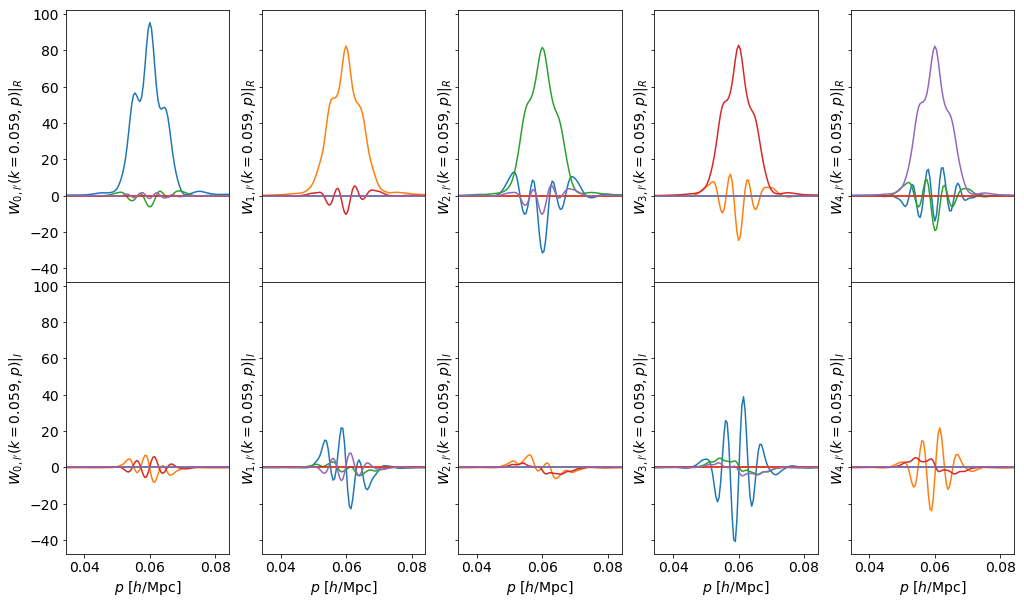

In [18]:
fig, ax = plt.subplots(2,5, figsize=(17, 10), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.2, hspace=0.)

idk = 5
for l in range(5):
    for m in range(5):
        ax[0,l].plot(p_arr, np.real(Wlm_cic_bin[l,m,idk]) * p_arr**2)
        ax[1,l].plot(p_arr, np.imag(Wlm_cic_bin[l,m,idk]) * p_arr**2)
    for i in range(2):
        ax[i,l].set_xlim(k_data[idk]-0.025, k_data[idk]+0.025)
    ax[0,l].set_ylabel(r"$W_{%s,l^\prime}(k=%.3f,p)|_R$" % (l,k_data[idk]))
    ax[1,l].set_ylabel(r"$W_{%s,l^\prime}(k=%.3f,p)|_I$" % (l,k_data[idk]))
    ax[1,l].set_xlabel(r'$p \ [h/{\rm Mpc}]$')

plt.show()

Check again that the sum over $p$ is equal to the window normalization in the limit of $k\rightarrow \infty$: $\sum_p \Delta p \ p^2 W_{0,0}(k, p) = Q_0(s\rightarrow 0)$

In [19]:
for i, k in enumerate(k_data):
    norm = np.sum(np.real(Wlm_cic_bin[0, 0]) * p_arr**2 * deltap, axis=-1)[i] / Qs[0,0]
    print ('%.3f:%.2f' % (k, norm), end = ' | ')

0.005:0.98 | 0.016:1.00 | 0.027:1.00 | 0.038:1.00 | 0.048:1.00 | 0.059:1.00 | 0.070:1.00 | 0.081:1.00 | 0.092:1.00 | 0.102:1.00 | 0.113:1.00 | 0.124:1.00 | 0.135:1.00 | 0.145:1.00 | 0.156:1.00 | 0.167:1.00 | 0.178:1.00 | 0.188:1.00 | 0.199:1.00 | 0.210:1.00 | 0.221:1.00 | 0.232:1.00 | 0.242:1.00 | 0.253:1.00 | 0.264:1.00 | 0.275:1.00 | 0.285:1.00 | 0.296:1.00 | 0.307:1.00 | 0.318:1.00 | 0.329:1.00 | 0.339:1.00 | 0.350:1.00 | 0.361:1.00 | 0.372:1.00 | 0.382:1.00 | 0.393:1.00 | 

Save files

In [20]:
filename = 'Wlmkp_n%s_boss_%s_%s.npz' % (nwide, red, sky)
np.savez(os.path.join('Wlmkp', filename), p=p_arr, Wlm_c=Wlm_c, Wlm_cic=Wlm_cic, Wlm_cic_bin=Wlm_cic_bin)

if nwide == 0: # for PyBird pipeline
    filename = 'Wlmkp_boss_%s_%s.npz' % (red, sky)
    np.savez(os.path.join('Wlmkp', filename), p=p_arr, k=k_data, 
             Wlm=np.real(Wlm_cic_bin[::2,::2]) * p_arr**2 * deltap)